In [1]:
import gymnasium as gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt

#Code implementations derived from from https://github.com/mimoralea/gdrl

## Generalized Policy Iteration

- Most RL agents follow the GPI loop consisting of two main steps:
    - **Policy Evaluation**: Gathers and estimates the action-value function $Q_{\pi}(s,a)$ for a given policy $\pi(s)$
    - **Policy Improvement**: Change policy to make it greedier with respect to the action-value function: $\pi'(s)=\underset{a\in A}{\mathrm{argmax}}\;Q_\pi(s,a)$
- Goal is to converge towards optimal value function $V^*(s)$ and policy $\pi^*(s)$

In [2]:
#Only a code template, implementations will vary 
def GPI(env, pi, Q, policy_evaluation, policy_improvement, init, update, max_iterations=10000):
    init()
    for _ in range(max_iterations):
        Q = policy_evaluation(pi, Q, env)
        pi, stop = policy_improvement(pi, Q)
        if stop: break
        update()
    return pi

### Helper Functions

#### Decay Schedule

- Generates an array of exponentially decaying values
- Used to decay parameters related to exploration/learning ($\epsilon$ and $\alpha$) over time
- More efficient to generate values using np vectorization than within loop

In [3]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1] #generate inverse log curve
    values = (values - values.min()) / (values.max() - values.min()) #normalize to [0, 1]
    values = (init_value - min_value) * values + min_value #transform to [min_value, init_value]
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

##### $\epsilon$-Greedy Select

- Select action at random with probability $\epsilon$
- Otherwise, select action greedily with respect to action-value function $Q(s,a)$ at state $s$

In [4]:
def epsilon_greedy_select(Q, state, epsilon):
    return np.argmax(Q[state]) if np.random.random() > epsilon else np.random.randint(len(Q[state]))    

#### Generate Trajectory

- Run a single episode and generate a list of *experiences*, tuples of $(S_t, A_t, R_{t+1}, S_{t+1})$, also known as the episode's ***trajectory***
- Trajectory must end at terminal state
- A completed episode's trajectory is used for *offline* processing and updating such as Monte Carlo Prediction

In [5]:
def generate_trajectory(select_action, env, max_steps=200):
    while True: #loop until we get a complete episode
        #reset environment and trajectory
        state = env.reset()[0]
        trajectory = []

        for t in count():
            action = select_action(state)

            next_state, reward, done = env.step(action)[:3]
            trajectory.append((state, action, reward, next_state)) #append experience tuple

            if done: return np.array(trajectory, object) #return trajectory as an np array
            if t >= max_steps - 1: break #reached max steps (reset environment and try again)
            
            state = next_state

### Monte Carlo Control

- Monte Carlo prediction policy evaluation
- $\epsilon$-greedy policy improvement

#### Monte Carlo Prediction

- Updates *offline* using episode trajectory
- For all times $t$, calculate return $G_t$ (immediate reward + sum of discounted future rewards) for state $S_t$
    - **First-Visit MC** only uses the return from the first time each state is encountered
    - **Every-Visit MC** uses all returns, regardless of multiple visits to the same state
- Incrementally update $Q$ estimate with learning hyperparameter $\alpha$
    - $Q(S_t, A_t) = Q(S_t, A_t) + \alpha(G_t-Q(S_t, A_t))$

In [6]:
def monte_carlo_prediction(pi, Q, env, alpha, discounts, first_visit=True, max_steps=200):
    trajectory = generate_trajectory(pi, env, max_steps)
    visited = np.zeros((env.observation_space.n, env.action_space.n), dtype=np.float64)

    for t, (state, action, reward, _,) in enumerate(trajectory):
        if first_visit and visited[state][action]: #skip if using First Visit MC and state already visited
            continue
        visited[state][action]=True

        n_steps = len(trajectory[t:])
        G = np.sum(discounts[:n_steps] * trajectory[t:, 2]) #calculate return
        Q[state][action] = Q[state][action] + alpha * (G - Q[state][action]) #incrementally update Q estimate
    return Q


#### $\epsilon$-Greedy Improvement

In [7]:
#Returns epsilon-greedy policy with given action-value function and epsilon
def epsilon_greedy_improvement(Q, epsilon):
    greedy = {s:a for s,a in enumerate(np.argmax(Q, axis=1))}
    return lambda s: greedy[s] if np.random.random() > epsilon else np.random.randint(len(Q[s]))

#### Full Algorithm

In [8]:
def monte_carlo_control(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5, 
                        init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9, n_episodes=3000, max_steps=200, first_visit=True):
    
    #pre-compute discounts (gamma) and decaying hyperparameters (alpha, epsilon) ahead of iteration
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False) #discounts = [1, gamma**2, ..., gamma**(max_steps-1)]
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes) #exponentially decaying alphas
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes) #exponentially decaying epsilons

    nS, nA = env.observation_space.n, env.action_space.n
    #saving pi/Q after each episode for analysis
    pi_track = []
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    #initialize Q
    Q = np.zeros((nS, nA), dtype=np.float64)

    #GPI loop
    for e in range(n_episodes):
        pi = epsilon_greedy_improvement(Q, epsilons[e]) #generate epsilon-greedy policy (policy improvement)
        Q = monte_carlo_prediction(pi, Q, env, alphas[e], discounts, first_visit, max_steps) #policy evaluation

        #store pi/Q for this episode
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1)) #save always-greedy policyx

    #Return value function (V) and greedy policy from GPI
    V = np.max(Q, axis=1)
    pi = np.argmax(Q, axis=1)
    return V, pi, Q_track, pi_track
    

#### Convergence of MC Control

- *Greedy in the Limit with Infinite Exploration (GLIE)*
    - All state-action pairs are explored infinitely many times: $\underset{k\to\infty}\lim N_k(s,a)=\infty$
    - The policy converges to greedy policy: $\underset{k\to\infty}\lim\pi(a|s) = \underset{a\in A}{\mathrm{argmax}}\;Q(s,a)$ with probability $1$
    - GLIE example: $\epsilon$-greedy where $\epsilon$ reduces to 0 at $\epsilon_k=1/k$ 
- GLIE Monte Carlo Control converges to the optimal value function $Q(s,a)\to q_*(s,a)$

### SARSA

- Temporal Difference (TD(0)) prediction policy evaluation
- $\epsilon$-greedy policy improvement

#### Temporal Difference (TD(0))

- Learns directly from episodes of experience (online), by *bootstrapping*
- Updates a guess towards a guess
- At each step $t$, use **$(S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1})$** to update the $Q$ estimate, with learning hyperparameter $\alpha$
    - $Q(S_t, A_t) = Q(S_t, A_t) + \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})-Q(S_t, A_t))$

In [9]:
def temporal_difference(pi, Q, env, state, alpha, gamma):
    action = pi(state) #Select action A_t for state S_t
    
    #Take action A_t and get R_{t+1}, S_{t+1}, and A_{t+1}
    next_state, reward, done = env.step(action)[:3]
    next_action = pi(next_state)

    #incrementally update Q estimate (NOTE: we multiply Q(S_{t+1}, A_{t+1}) by (not done) because there is no future rewards/value at terminal state)
    Q[state][action] = Q[state][action] + alpha * (reward + gamma*Q[next_state][next_action]*(not done) - Q[state][action])

    return Q, next_state, done


#### Comparisons between Monte Carlo and Temporal Difference

- TD can learn online after every step; MC must learn offline from complete episodes
- TD works in continuing (non-terminating) environments; MC only works in episodic (terminating) environments
- MC has high variance, zero bias; TD has low variance, some bias
- TD is usually more efficient than MC, but more sensitive to initial value
- MC can converge to $Q_\pi(s,a)$, even with function approximation, TD(0) converges, but not always with function approximation

#### Full Algorithm

In [10]:
def sarsa(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5, 
          init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9, n_episodes=3000):
    
    #pre-compute decaying hyperparameters (alpha, epsilon) ahead of iteration
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes) #exponentially decaying alphas
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes) #exponentially decaying epsilons

    nS, nA = env.observation_space.n, env.action_space.n
    #saving pi/Q after each episode for analysis
    pi_track = []
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    #initialize Q
    Q = np.zeros((nS, nA), dtype=np.float64)


    for e in range(n_episodes):
        state, done = env.reset()[0], False #initialize environment at the start of each episode

        #GPI loop (online learning)
        while not done: #repeat until terminal state
            pi = epsilon_greedy_improvement(Q, epsilons[e]) #generate epsilon-greedy policy (policy improvement)
            Q, state, done = temporal_difference(pi, Q, env, state, alphas[e], gamma) #update Q using TD and go to next state for processing

        #store pi/Q for this episode
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1)) #save always-greedy policyx

    #Return value function (V) and greedy policy from GPI
    V = np.max(Q, axis=1)
    pi = np.argmax(Q, axis=1)
    return V, pi, Q_track, pi_track
    

#### Convergence of SARSA

- SARSA converges to the optimal action-value function, $Q(s,a)\to q_*(s,a)$, if:
    - GLIE sequence of policies $\pi_t(a|s)$
    - Robbins-Monro sequence of step-sizes $\alpha_t$
        - $$\sum_{t=1}^\infty \alpha_t = \infty$$
        - $$\sum_{t=1}^\infty \alpha_t^2 < \infty$$

### Q-Learning

- *Off-policy* learning method
    - Behavior policy (random, $\epsilon$-greedy, etc.) generates data
    - Target policy (greedy to $Q(s,a)$) is evaluated and improved

#### Q-learning updates

- Updates online, like SARSA
- Only difference is replacing $Q(S_{t+1},A_{t+1})$ with $\underset{a}\max\;Q(S_{t+1},a)$
- At each step $t$, use **$(S_t, A_t, R_{t+1}, S_{t+1})$** to update the $Q$ estimate, with learning hyperparameter $\alpha$
    - $Q(S_t, A_t) = Q(S_t, A_t) + \alpha(R_{t+1}+\gamma \underset{a}\max\;Q(S_{t+1},a)-Q(S_t, A_t))$

In [11]:
def q_update(pi, Q, env, state, alpha, gamma):
    action = pi(state) #Select action A_t for state S_t
    
    #Take action A_t and get R_{t+1}, S_{t+1}
    next_state, reward, done = env.step(action)[:3]

    #incrementally update Q estimate (NOTE: we multiply max Q(S_{t+1}) by (not done) because there is no future rewards/value at terminal state)
    Q[state][action] = Q[state][action] + alpha * (reward + gamma*Q[next_state].max()*(not done) - Q[state][action])

    return Q, next_state, done


#### Full Algorithm

- Same as SARSA, only difference is using *q_update* instead of *temporal_difference*

In [12]:
def q_learning(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5, 
          init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9, n_episodes=3000):
    
    #pre-compute decaying hyperparameters (alpha, epsilon) ahead of iteration
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes) #exponentially decaying alphas
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes) #exponentially decaying epsilons

    nS, nA = env.observation_space.n, env.action_space.n
    #saving pi/Q after each episode for analysis
    pi_track = []
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    #initialize Q
    Q = np.zeros((nS, nA), dtype=np.float64)


    for e in range(n_episodes):
        state, done = env.reset()[0], False #initialize environment at the start of each episode

        #GPI loop (online learning)
        while not done: #repeat until terminal state
            pi = epsilon_greedy_improvement(Q, epsilons[e]) #generate epsilon-greedy policy (policy improvement)
            Q, state, done = q_update(pi, Q, env, state, alphas[e], gamma) #update Q and go to next state for processing

        #store pi/Q for this episode
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1)) #save always-greedy policyx

    #Return value function (V) and greedy policy from GPI
    V = np.max(Q, axis=1)
    pi = np.argmax(Q, axis=1)
    return V, pi, Q_track, pi_track
    

### Double Q-Learning

- Q-learning uses the maximum over *estimates* of $Q$, resulting in *maximization bias*
    - Estimates are *bootstrapped*, often with bias
- Double Q-learning tracks two Q estimates, $Q_1$, and $Q_2$
    - Policy is greedy with respect to $(Q_1+Q_2)/2$

#### Double Q-learning updates

- With $0.5$ probability, update $Q_1$ as follows:
    - $Q_1(S_t, A_t) = Q_1(S_t, A_t) + \alpha(R_{t+1}+\gamma Q_2(S_{t+1},\underset{a\in A}{\mathrm{argmax}}\;Q_1(S_{t+1},a))-Q_1(S_t, A_t))$
- Else, update $Q_2$ using the above (switch $Q_1$ and $Q_2$)

In [13]:
def double_q_update(pi, Q1, Q2, env, state, alpha, gamma):
    action = pi(state) #Select action A_t for state S_t
    
    #Take action A_t and get R_{t+1}, S_{t+1}
    next_state, reward, done = env.step(action)[:3]

    #incrementally update Q estimate (NOTE: we multiply max Q(S_{t+1}) by (not done) because there is no future rewards/value at terminal state)
    if np.random.randint(2):
        next_action = np.argmax(Q1[next_state])
        Q1[state][action] = Q1[state][action] + alpha * (reward + gamma*Q2[next_state][next_action]*(not done) - Q1[state][action])
    else:
        next_action = np.argmax(Q2[next_state])
        Q2[state][action] = Q2[state][action] + alpha * (reward + gamma*Q1[next_state][next_action]*(not done) - Q2[state][action])
    
    return Q1, Q2, next_state, done


### Full Algorithm

In [14]:
def double_q_learning(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5, 
          init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9, n_episodes=3000):
    
    #pre-compute decaying hyperparameters (alpha, epsilon) ahead of iteration
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes) #exponentially decaying alphas
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes) #exponentially decaying epsilons

    nS, nA = env.observation_space.n, env.action_space.n
    #saving pi/Q after each episode for analysis
    pi_track = []
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    #initialize Q1, Q2, Q
    Q1 = np.zeros((nS, nA), dtype=np.float64)
    Q2 = np.zeros((nS, nA), dtype=np.float64)
    Q = np.zeros((nS, nA), dtype=np.float64)

    for e in range(n_episodes):
        state, done = env.reset()[0], False #initialize environment at the start of each episode

        #GPI loop (online learning)
        while not done: #repeat until terminal state
            pi = epsilon_greedy_improvement(Q, epsilons[e]) #generate epsilon-greedy policy with respect to Q1+Q2 (functionally same as mean(Q1,Q2))
            Q1, Q2, state, done = double_q_update(pi, Q1, Q2, env, state, alphas[e], gamma) #update Q1/Q2 and go to next state for processing
            Q = (Q1+Q2)/2

        #store pi/Q for this episode
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1)) #save always-greedy policy

    #Return value function (V) and greedy policy from GPI
    V = np.max(Q, axis=1)
    pi = np.argmax(Q, axis=1)
    return V, pi, Q_track, pi_track
    

## Testing GPI Methods

In [15]:
def test_policy(env, pi, num_episodes, gamma=1.0):
    res = []
    for episode in range(num_episodes):
        num_steps = 0
        ret = 0.0
        observation, info = env.reset()
        while True:
            action = pi[observation]
            observation, reward, terminated, truncated, info = env.step(action)
            ret += gamma**num_steps * reward
            num_steps += 1
            if terminated or truncated:
                res.append((episode, reward==1.0, num_steps, ret))
                break
    env.close()
    return np.array(res, dtype=[('episode','int'),('goal', 'bool'),('num_steps','int'),('return','float')])

In [16]:
def print_results(res, V):
    print(f"Success Rate: {res['goal'].mean()}")
    print(f'Expected Return: {V[0]}')
    print(f"Mean Actual Return: {res['return'].mean()}")
    print(f"Average step count for successful episodes: {res['num_steps'].mean(where=res['goal'])}")

In [17]:
def test_and_compare_rl_methods(env, num_tests=1, gamma=1.0, **kwargs):
    rl_tests = {}

    rl_tests['First Visit MC'] = monte_carlo_control(env, gamma, **kwargs)
    rl_tests['Every Visit MC'] = monte_carlo_control(env, gamma, first_visit=False, **kwargs)
    rl_tests['SARSA'] = sarsa(env, gamma, **kwargs)
    rl_tests['Q Learning'] = q_learning(env, gamma, **kwargs)
    rl_tests['Double Q Learning'] = double_q_learning(env, gamma, **kwargs)
    
    _, ax = plt.subplots(figsize=(15,6))

    #show value function estimates after each episode
    for method, test in rl_tests.items():
        V, pi, Q_track, _ = test
        res = test_policy(env, pi, num_tests, gamma=gamma)
        print('======================\n'+method+'\n======================')
        print_results(res, V)
        ax.plot(np.arange(0, len(Q_track)), Q_track[:,0].max(axis=1), linewidth=1, alpha=0.5, label=method)

    ax.set_title('Optimal value estimate after each episode')
    ax.legend()
    plt.show()

    _, ax = plt.subplots(figsize=(15,6))

    #show average return of policies for each episode
    for method, test in rl_tests.items():
        _, _, _, pi_track = test
        mean_returns = np.zeros(len(pi_track)) #mean return for each policy after each episode of GPI
        for e, pi in enumerate(pi_track):
            res = test_policy(env, pi, num_tests, gamma=gamma)
            mean_returns[e] = res['return'].mean()
        ax.plot(np.arange(0, len(pi_track)), mean_returns, linewidth=1, alpha=0.5, label=method)
    
    ax.set_title('Mean return of policy after each episode')
    ax.legend()
    plt.show()
    

#### 4x4 FrozenLake (Non-Slippery)

First Visit MC
Success Rate: 1.0
Expected Return: 0.950981279948839
Mean Actual Return: 0.9509900498999999
Average step count for successful episodes: 6.0
Every Visit MC
Success Rate: 1.0
Expected Return: 0.9508738524942949
Mean Actual Return: 0.9509900498999999
Average step count for successful episodes: 6.0
SARSA
Success Rate: 1.0
Expected Return: 0.9484611089946471
Mean Actual Return: 0.9509900498999999
Average step count for successful episodes: 6.0
Q Learning
Success Rate: 1.0
Expected Return: 0.9509900498999987
Mean Actual Return: 0.9509900498999999
Average step count for successful episodes: 6.0
Double Q Learning
Success Rate: 1.0
Expected Return: 0.950990049899998
Mean Actual Return: 0.9509900498999999
Average step count for successful episodes: 6.0


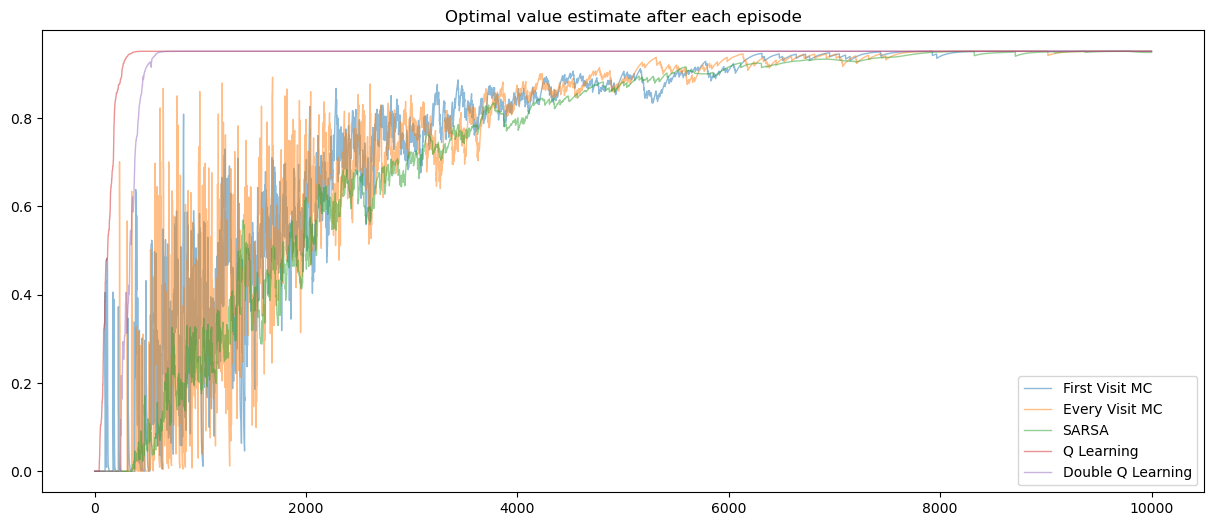

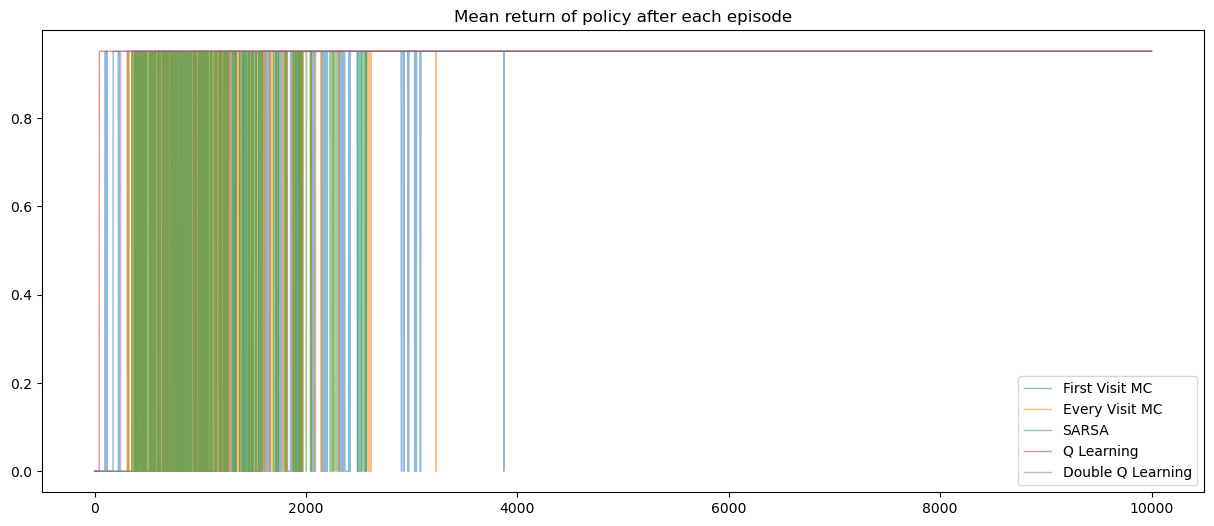

In [81]:
env=gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=False)

test_and_compare_rl_methods(env, gamma=0.99, init_alpha=0.5, alpha_decay_ratio=0.5, epsilon_decay_ratio=0.8, min_epsilon=0.001, n_episodes=10000)

#### 4x4 FrozenLake (Slippery)

First Visit MC
Success Rate: 0.74
Expected Return: 0.5091078940169442
Mean Actual Return: 0.5206091386832356
Average step count for successful episodes: 37.986486486486484
Every Visit MC
Success Rate: 0.07
Expected Return: 0.045453772671310504
Mean Actual Return: 0.059063271237941965
Average step count for successful episodes: 18.285714285714285
SARSA
Success Rate: 0.72
Expected Return: 0.5325544717207192
Mean Actual Return: 0.5142759463245555
Average step count for successful episodes: 36.80555555555556
Q Learning
Success Rate: 0.81
Expected Return: 0.5456288566204035
Mean Actual Return: 0.5820417371651841
Average step count for successful episodes: 36.32098765432099
Double Q Learning
Success Rate: 0.72
Expected Return: 0.5454831704700165
Mean Actual Return: 0.5063200028793005
Average step count for successful episodes: 38.263888888888886


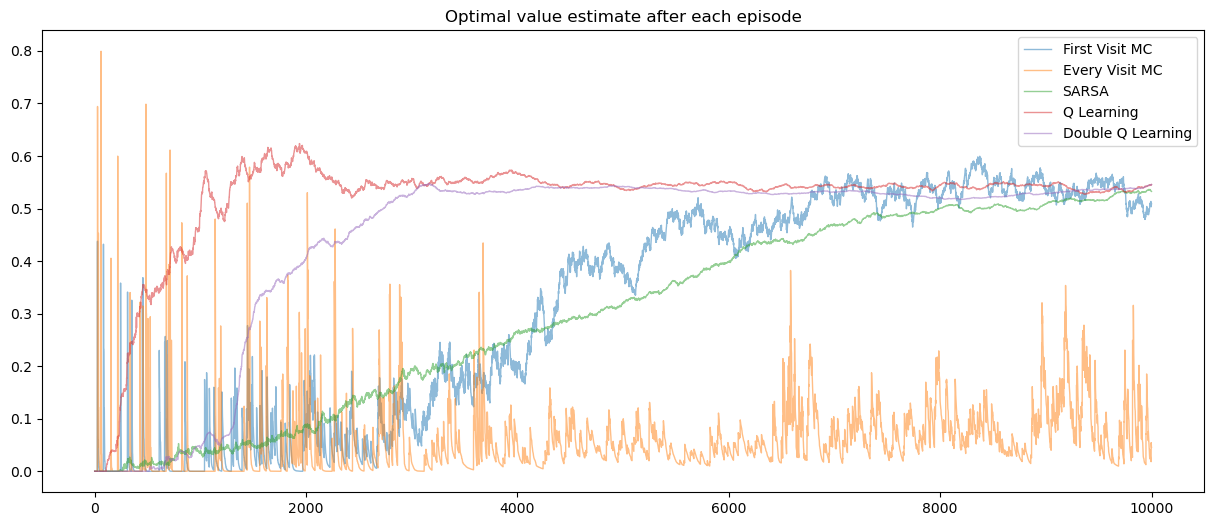

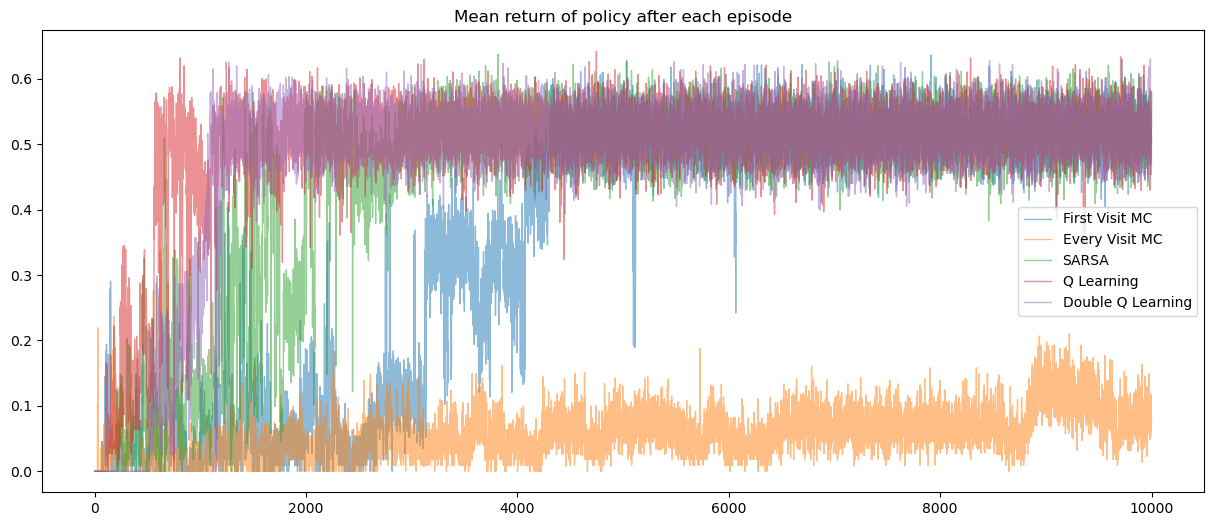

In [82]:
#env=gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True)
#
#test_and_compare_rl_methods(env, gamma=0.99, num_tests=10, init_alpha=0.5, alpha_decay_ratio=0.5, epsilon_decay_ratio=0.8, min_epsilon=0.001, n_episodes=10000)

### Visualizing Estimated Value Updates

In [18]:
import gymnasium as gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import pygame

#### Update Q-update to show Q values in rendered environment

In [35]:
pygame.init()
font = pygame.font.SysFont('Comic Sans MS', 16)
actions = ['left', 'down', 'right', 'up'] #names of actions in action space

def q_update(pi, Q, env, state, alpha, gamma):

    action = pi(state) #Select action A_t for state S_t
    
    #Take action A_t and get R_{t+1}, S_{t+1}
    next_state, reward, done = env.step(action)[:3]

    #incrementally update Q estimate (NOTE: we multiply max Q(S_{t+1}) by (not done) because there is no future rewards/value at terminal state)
    Q[state][action] = Q[state][action] + alpha * (reward + gamma*Q[next_state].max()*(not done) - Q[state][action])

    for y in range(env.nrow):
        for x in range(env.ncol):
            pos = (x*env.cell_size[0], y*env.cell_size[1])
            s = y*env.ncol + x
            text = font.render(str(np.round(Q[s].max(), 3)), False, (0, 0, 0))
            env.window_surface.blit(text, pos)
            if Q[s].max() > 0:
                action_text = font.render(actions[np.argmax(Q[s])], False, (0, 0, 0))
                env.window_surface.blit(action_text, (pos[0], pos[1]+24))

    env.window_surface.blit(font.render('alpha=' + str(np.round(alpha,3)), False, (255, 0, 0)), (env.window_size[0]/2-32, env.window_size[1]/2-16))
    pygame.event.pump()
    pygame.display.update()
    env.clock.tick(fps)

    return Q, next_state, done


In [43]:
env=gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True, render_mode='human')
env.metadata['render_fps']=0
fps = 200
q_learning(env, gamma=0.99, init_alpha=0.5, alpha_decay_ratio=0.9, epsilon_decay_ratio=0.7, min_epsilon=0.001, n_episodes=3000)

(array([0.55382545, 0.49723818, 0.46971622, 0.4564623 , 0.57225313,
        0.        , 0.34492831, 0.        , 0.60672124, 0.64675553,
        0.62934702, 0.        , 0.        , 0.74257672, 0.87356428,
        0.        ]),
 array([0, 3, 3, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0], dtype=int64),
 array([[[0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0

In [44]:
env.close()